## Calculating  azimuth (Orientation):
Azimuth angle is the compass direction from which the sunlight is coming. At solar noon, the sun is always directly south in the northern hemisphere and directly north in the southern hemisphere. ... The azimuth angle is like a compass direction with North = 0° and South = 180°.

We'll convert a GeoJson file to its correspond geojson and then back to GeoJson to memic the model output.
The "predicted" mask will be used to extract oriantation for each building.
We'll compare the results with the original.

In [ ]:
import solaris as sol
import os
import skimage
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import math
import cv2

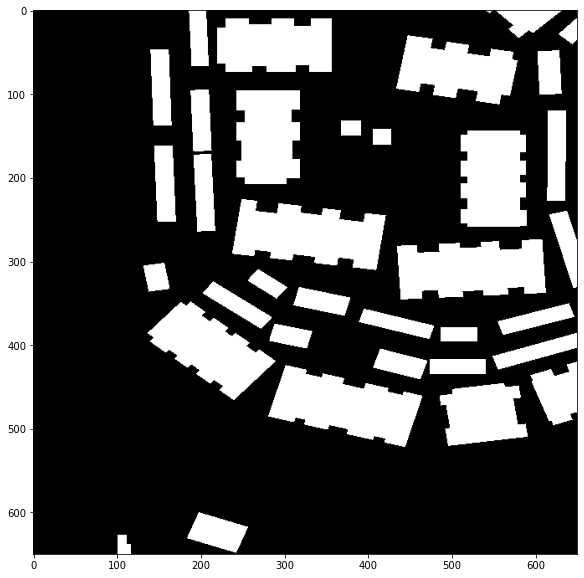

In [29]:
# Convert GeoJson to binary mask
# Load a binary mask 
data_dir = 'D:/SpaceNet_TrainData/train/AOI_2_Vegas/Vegas_tif'
#SN2_buildings_train_AOI_2_Vegas_PS-RGB_img18.tif
geojson_dir = 'D:/SpaceNet_TrainData/train/AOI_2_Vegas/geojson_buildings'
file = 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img18.geojson'
fp_mask = sol.vector.mask.footprint_mask(df=os.path.join(geojson_dir, file),
                                      reference_im=os.path.join(data_dir, 'SN2_buildings_train_AOI_2_Vegas_PS-RGB_img18.tif'))
f, ax = plt.subplots(figsize=(10, 10))
plt.imshow(fp_mask, cmap='gray')

In [31]:
# Save our mask as tif image
from PIL import Image
im = Image.fromarray(fp_mask)
im.save('D:/SpaceNet_TrainData/train/AOI_2_Vegas/test.tif')

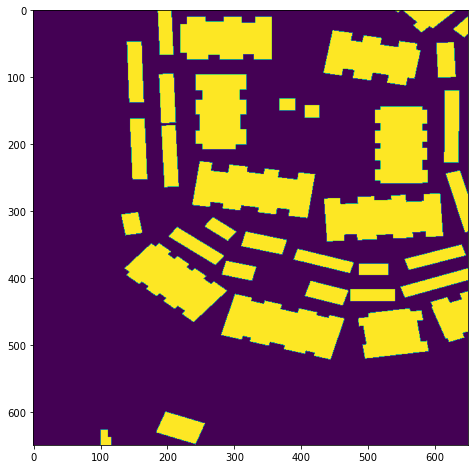

In [32]:
# Load the mask
mask_image = skimage.io.imread(os.path.join('D:/SpaceNet_TrainData/train/AOI_2_Vegas/test.tif'))

f, ax = plt.subplots(figsize=(10, 8))
plt.imshow(mask_image)

In [34]:
# Convert the mask to vector data
geoms = sol.vector.mask.mask_to_poly_geojson(mask_image, output_path='D:/SpaceNet_TrainData/train/AOI_2_Vegas/test_geo.geojson',
                                            output_type='geojson', )

In [143]:
pred_geo = gpd.read_file('D:/SpaceNet_TrainData/train/AOI_2_Vegas/test_geo.geojson')
pred_geo.head(2)
#print(pred_geo.crs)

,value,geometry
0,255.0,"POLYGON ((553.000 0.000, 553.000 1.000, 554.00..."
1,255.0,"POLYGON ((649.000 10.000, 649.000 11.000, 648...."


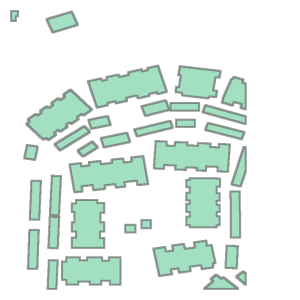

In [36]:
from shapely.ops import cascaded_union
cascaded_union(geoms['geometry'])

In [142]:
gdf = gpd.read_file(os.path.join(geojson_dir, file))
gdf.head(2)

,OBJECTID,FID_VEGAS_,Id,FID_Vegas,Name,AREA,Shape_Leng,Shape_Le_1,SISL,OBJECTID_1,Shape_Le_2,Shape_Le_3,Shape_Area,partialBuilding,partialDec,geometry
0,0,0,0,0,None,0.0,0.0,0.0,0.0,0,153.353,0.001255,0.0,0.0,1.0,"POLYGON Z ((-115.30655 36.15811 0.00000, -115...."
1,0,0,0,0,None,0.0,0.0,0.0,0.0,0,150.495,0.001208,0.0,0.0,1.0,"POLYGON Z ((-115.30668 36.15781 0.00000, -115...."


## Getting the actual angle given a vector data

In [45]:
def get_azimuth(geom):
    '''takes a geometry  and returns the angle '''
    a = g.minimum_rotated_rectangle
    l = a.boundary
    coords = [c for c in l.coords]
    segments = [shapely.geometry.LineString([a, b]) for a, b in zip(coords,coords[1:])]
    longest_segment = max(segments, key=lambda x: x.length)

    p1, p2 = [c for c in longest_segment.coords]
    angle = math.degrees(math.atan2(p2[1]-p1[1], p2[0]-p1[0]))
    return angle


In [70]:
# Try it on the original geojson
gdf = gpd.read_file(os.path.join(geojson_dir, file))
list_azimuth = []
for i in range(len(gdf)):
    g = gdf.iloc[i].geometry
    angle = get_azimuth(g)
    angle_building_dic = {}
    angle_building_dic = {'geometry' : g, 'angle' : angle}
    list_azimuth.append(angle_building_dic)

gdf = gpd.GeoDataFrame(list_azimuth)
    
    


In [76]:
# Test it on the one we converted from our binary mask

list_azimuth = []
for i in range(len(pred_geo)):
    g = gdf.iloc[i].geometry
    angle = get_azimuth(g)
    angle_building_dic = {}
    angle_building_dic = {'geometry' : g, 'angle' : angle}
    list_azimuth.append(angle_building_dic)

predicted_gdf = gpd.GeoDataFrame(list_azimuth)
    

In [77]:
predicted_gdf.head()

,geometry,angle
0,"POLYGON Z ((-115.30655 36.15811 0.00000, -115....",180.000000
1,"POLYGON Z ((-115.30668 36.15781 0.00000, -115....",90.000000
2,"POLYGON Z ((-115.30680 36.15748 0.00000, -115....",173.550909
3,"POLYGON Z ((-115.30587 36.15739 0.00000, -115....",-177.395598
4,"POLYGON Z ((-115.30595 36.15774 0.00000, -115....",90.232491


### Refernece
- https://gis.stackexchange.com/questions/380499/calculate-azimuth-from-polygon-in-geopandas
- https://stackoverflow.com/questions/42258637/how-to-know-the-angle-between-two-points
- https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_mask_to_vector.html
- https://stackoverflow.com/questions/55522395/how-do-i-plot-shapely-polygons-and-objects-using-matplotlib


In [1]:
'''
geo_dir = 'D:/SpaceNet_TrainData/train/AOI_2_Vegas/geojson_buildings'
gdf = gpd.read_file(os.path.join(geo_dir, 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1.geojson'))
# Let's calculate the oriantation for the third entry 
g = df.iloc[2].geometry
a = g.minimum_rotated_rectangle
l = a.boundary

# Get the coordinates for the boundary line
coords = [c for c in l.coords]
segments = [shapely.geometry.LineString([a, b]) for a, b in zip(coords,coords[1:])]
longest_segment = max(segments, key=lambda x: x.length)

p1, p2 = [c for c in longest_segment.coords]
angle = math.degrees(math.atan2(p2[1]-p1[1], p2[0]-p1[0])) 
line = gpd.GeoSeries(l)
rot_rect = gpd.GeoSeries(a)
geom = gpd.GeoSeries(g)

line.plot()'''

"\ngeo_dir = 'D:/SpaceNet_TrainData/train/AOI_2_Vegas/geojson_buildings'\ngdf = gpd.read_file(os.path.join(geo_dir, 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1.geojson'))\n# Let's calculate the oriantation for the third entry \ng = df.iloc[2].geometry\na = g.minimum_rotated_rectangle\nl = a.boundary\n\n# Get the coordinates for the boundary line\ncoords = [c for c in l.coords]\nsegments = [shapely.geometry.LineString([a, b]) for a, b in zip(coords,coords[1:])]\nlongest_segment = max(segments, key=lambda x: x.length)\n\np1, p2 = [c for c in longest_segment.coords]\nangle = math.degrees(math.atan2(p2[1]-p1[1], p2[0]-p1[0])) "